In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


## 数据准备

In [2]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2025-01-24 11:14:11--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.217.91, 142.251.215.251, 142.250.217.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.217.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'shakespeare.txt.2'

     0K .......... .......... .......... .......... ..........  4% 95.3K 11s
    50K .......... .......... .......... .......... ..........  9%  184K 8s
   100K .......... .......... .......... .......... .......... 13%  238K 6s
   150K .......... .......... .......... .......... .......... 18%  395K 5s
   200K .......... .......... .......... .......... .......... 22%  638K 4s
   250K .......... .......... .......... .......... .......... 27%  275K 4s
   300K .......... .......... .......... .......... .......... 32% 1.12M 3s
   350K .......... .......... ..........

In [3]:
# https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
#文件已经下载好了
with open("./shakespeare.txt", "r", encoding="utf8") as file:
    text = file.read()

print("length", len(text))
print(text[0:100])

length 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 构造字典

In [4]:
# 1. generate vocab
# 2. build mapping char->id
# 3. data -> id_data  把数据都转为id
# 4. a b c d [EOS] -> [BOS] b c d  预测下一个字符生成的模型，也就是输入是a，输出就是b

#去重，留下独立字符，并排序（排序是为了好看）
vocab = sorted(set(text))
print(len(vocab))
print(vocab)

65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
for idx,char in enumerate(['h','o','w']):
    print(idx,char)

0 h
1 o
2 w


In [6]:
#每个字符都编好号，enumerate对每一个位置编号，生成的是列表中是元组，下面字典生成式
char2idx = {char:idx for idx, char in enumerate(vocab)}
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [7]:
# 把vocab从列表变为ndarray
idx2char = np.array(vocab)
print(idx2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [8]:
#把字符都转换为id
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int.shape)
print(len(text_as_int))
print(text_as_int[0:10])
print(text[0:10])

(1115394,)
1115394
[18 47 56 57 58  1 15 47 58 47]
First Citi


In [9]:
1115394//101

11043

### 把莎士比亚文集分成一个一个的样本

In [10]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    #text_as_int是字符的id列表，seq_length是每个样本的长度
    def __init__(self, text_as_int, seq_length):
        self.sub_len = seq_length + 1 #一个样本的长度
        self.text_as_int = text_as_int
        self.num_seq = len(text_as_int) // self.sub_len #样本的个数
        
    def __getitem__(self, index):#index是样本的索引，返回的是一个样本，比如第一个，就是0-100的字符,总计101个字符
        return self.text_as_int[index * self.sub_len: (index + 1) * self.sub_len]
    
    def __len__(self): #返回样本的个数
        return self.num_seq

#batch是一个列表，列表中的每一个元素是一个样本，有101个字符，前100个是输入，后100个是输出
def collat_fct(batch):
    src_list = [] #输入
    trg_list = [] #输出
    for part in batch:
        src_list.append(part[:-1]) #输入
        trg_list.append(part[1:]) #输出
        
    src_list = np.array(src_list) #把列表转换为ndarray
    trg_list = np.array(trg_list) #把列表转换为ndarray
    return torch.Tensor(src_list).to(dtype=torch.int64), torch.Tensor(trg_list).to(dtype=torch.int64) #返回的是一个元组，元组中的每一个元素是一个torch.Tensor
        
#每个样本的长度是101，也就是100个字符+1个结束符
train_ds = CharDataset(text_as_int, 100)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collat_fct)

In [11]:
for datas, labels in train_dl:
    print(datas.shape)
    print(labels.shape)
    break

torch.Size([64, 100])
torch.Size([64, 100])


## 定义模型

In [12]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=1024):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #batch_first=True,输入的数据格式是(batch_size, seq_len, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        x = self.embedding(x) #(batch_size, seq_len) -> (batch_size, seq_len, embedding_dim) (64, 100, 256)
        #这里和02的差异是没有只拿最后一个输出，而是把所有的输出都拿出来了
        #(batch_size, seq_len, embedding_dim)->(batch_size, seq_len, hidden_dim)(64, 100, 1024)
        output, hidden = self.rnn(x, hidden)
        x = self.fc(output) #[bs, seq_len, hidden_dim]--->[bs, seq_len, vocab_size] (64, 100,65)
        return x, hidden #x的shape是(batch_size, seq_len, vocab_size)
    
    
vocab_size = len(vocab)

print("{:=^80}".format(" 一层单向 RNN "))       
for key, value in CharRNN(vocab_size).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

=================================== 一层单向 RNN ===================================
            embedding.weight            paramerters num: 16640
            rnn.weight_ih_l0            paramerters num: 262144
            rnn.weight_hh_l0            paramerters num: 1048576
             rnn.bias_ih_l0             paramerters num: 1024
             rnn.bias_hh_l0             paramerters num: 1024
               fc.weight                paramerters num: 66560
                fc.bias                 paramerters num: 65


In [13]:
print(65*256)
print(256*1024)
print(1024*1024)
1024*65

16640
262144
1048576


66560

In [14]:
sample_inputs = torch.randint(0, vocab_size, (3, 100))
print(sample_inputs.shape)
model = CharRNN(vocab_size)
output=model(sample_inputs)
output[0].shape

torch.Size([3, 100])


torch.Size([3, 100, 65])

In [15]:
output[0].reshape(-1, vocab_size).shape

torch.Size([300, 65])

In [16]:

1024*65

66560

## 训练

In [17]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [18]:
# 训练
def training(
    model, 
    train_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=None,
    stateful=False      # 想用stateful，batch里的数据就必须连续，不能打乱
    ):
    record_dict = {
        "train": [],
    }
    
    global_step = 0
    model.train()
    hidden = None
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算,如果数据集打乱了，stateful=False，hidden就要清空
                # 如果数据集没有打乱，stateful=True，hidden就不需要清空
                logits, hidden = model(datas, hidden=hidden if stateful else None)
                # 计算损失,交叉熵损失第一个参数要是二阶张量，第二个参数要是一阶张量，所以要reshape
                loss = loss_fct(logits.reshape(-1, vocab_size), labels.reshape(-1))
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
   
                # 保存模型权重 save model checkpoint
                if save_ckpt_callback is not None:
                    save_ckpt_callback(global_step, model.state_dict(), metric=-loss)
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = CharRNN(vocab_size=vocab_size)

# 1. 定义损失函数 采用交叉熵损失 
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/text_generation", save_step=1000, save_best_only=True)


model = model.to(device)


In [19]:
record = training(
    model,
    train_dl,
    epoch,
    loss_fct,
    optimizer,
    save_ckpt_callback=save_ckpt_callback,
    )

  0%|          | 0/17300 [00:00<?, ?it/s]

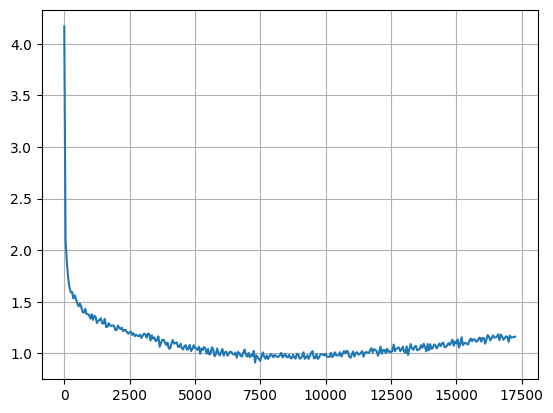

In [20]:
plt.plot([i["step"] for i in record["train"][::50]], [i["loss"] for i in record["train"][::50]], label="train")
plt.grid()
plt.show()

## 推理

In [21]:
#下面的例子是为了说明temperature
my_tensor = torch.tensor([0.4,0.6]) #这里是logits

probs1 = F.softmax(my_tensor, dim=-1)   # 计算输入张量 my_tensor 的 softmax 概率分布
print(probs1)

tensor([0.4502, 0.5498])


In [22]:
my_tensor = torch.tensor([0.2,0.3])  #现在 temperature是2

probs1 = F.softmax(my_tensor, dim=-1)
print(probs1)

tensor([0.4750, 0.5250])


In [23]:
import torch

# 创建一个概率分布，表示每个类别被选中的概率
# 这里我们有一个简单的四个类别的概率分布
prob_dist = torch.tensor([0.1, 0.45, 0.35, 0.1])

# 使用 multinomial 进行抽样
# num_samples 表示要抽取的样本数量
num_samples = 5

# 抽取样本，随机抽样，概率越高，抽到的概率就越高
samples = torch.multinomial(prob_dist, 1, replacement=True) 

print("概率分布:", prob_dist)
print("抽取的样本索引:", samples)

# 显示每个样本对应的概率
print("每个样本对应的概率:", prob_dist[samples])

概率分布: tensor([0.1000, 0.4500, 0.3500, 0.1000])
抽取的样本索引: tensor([2])
每个样本对应的概率: tensor([0.3500])


In [24]:
def generate_text(model, start_string, max_len=1000, temperature=1.0, stream=True):
    input_eval = torch.Tensor([char2idx[char] for char in start_string]).to(dtype=torch.int64, device=device).reshape(1, -1) #bacth_size=1, seq_len长度是多少都可以 （1,5）
    hidden = None
    text_generated = [] #用来保存生成的文本
    model.eval()
    pbar = tqdm(range(max_len)) # 进度条
    print(start_string, end="")
    # no_grad是一个上下文管理器，用于指定在其中的代码块中不需要计算梯度。在这个区域内，不会记录梯度信息，用于在生成文本时不影响模型权重。
    with torch.no_grad():
        for i in pbar:#控制进度条
            logits, hidden = model(input_eval, hidden=hidden)
            # 温度采样，较高的温度会增加预测结果的多样性，较低的温度则更加保守。
            #取-1的目的是只要最后，拼到原有的输入上
            logits = logits[0, -1, :] / temperature # logits此时是一维的，有65个元素，每个元素代表一个字符的概率
            # using multinomial to sampling
            probs = F.softmax(logits, dim=-1) #算为概率分布
            idx = torch.multinomial(probs, 1).item() #从概率分布中抽取一个样本,取概率较大的那些
            input_eval = torch.Tensor([idx]).to(dtype=torch.int64, device=device).reshape(1, -1) #把idx转为tensor
            text_generated.append(idx)
            if stream:
                print(idx2char[idx], end="", flush=True)
    return "".join([idx2char[i] for i in text_generated])


# load checkpoints
model.load_state_dict(torch.load("checkpoints/text_generation/best.ckpt", map_location="cpu"))
start_string = "All: " #这里就是开头，什么都可以
res = generate_text(model, start_string, max_len=1000, temperature=0.5, stream=True)

C:\Users\q1209\AppData\Local\Temp\ipykernel_23560\4273895067.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/text_generati

  0%|          | 0/1000 [00:00<?, ?it/s]

All: there is no more. The gods me not; so help you to him whose honest servison.

ISABELLA:
I will unfold that ever
I will tell the field
I' the place of holy and with my father's silence,
That thou resceed you to your grace,
For her mercy is my honour bring.

Nurse:
Have you not a strange brows with thee to the world,
And speak permit them on,
And thither will I be so;
That we hate her help.

Both Tribunes:
We have been so brief:
Thou hast no child and sorrow?
Now thou didst seek the statue of it.

BUCKINGHAM:
I fear me speak it.

GLOUCESTER:
Why, then will I see thee dead?

BIANCA:
It is my honour that hath deceived and tell me speak to thee;
For now will I read Hereford, Lord Angelo, how could buy be this while:
For her for the whole heart to say
Your friends, my lord.

KING RICHARD III:
And I am sure, to him that have married. I do beseech you, sir, he does me a man to see thee from the world.

LEONTES:
You were at the whole hours of wills that have done so, here will I know, my l

In [25]:
res

"there is no more. The gods me not; so help you to him whose honest servison.\n\nISABELLA:\nI will unfold that ever\nI will tell the field\nI' the place of holy and with my father's silence,\nThat thou resceed you to your grace,\nFor her mercy is my honour bring.\n\nNurse:\nHave you not a strange brows with thee to the world,\nAnd speak permit them on,\nAnd thither will I be so;\nThat we hate her help.\n\nBoth Tribunes:\nWe have been so brief:\nThou hast no child and sorrow?\nNow thou didst seek the statue of it.\n\nBUCKINGHAM:\nI fear me speak it.\n\nGLOUCESTER:\nWhy, then will I see thee dead?\n\nBIANCA:\nIt is my honour that hath deceived and tell me speak to thee;\nFor now will I read Hereford, Lord Angelo, how could buy be this while:\nFor her for the whole heart to say\nYour friends, my lord.\n\nKING RICHARD III:\nAnd I am sure, to him that have married. I do beseech you, sir, he does me a man to see thee from the world.\n\nLEONTES:\nYou were at the whole hours of wills that have

In [26]:
len(res)

1000